In [129]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from torchvision.datasets import FashionMNIST, MNIST, CIFAR10, SVHN
import torchvision
from torchvision import transforms
import torchvision.utils as vision_utils
import matplotlib.pyplot as plt
import random
import os
import time
import math

DEVICE = torch.device('cpu')

In [130]:
print(torch.cuda.is_available())
print(torch.cuda.device_count()) 

True
1


In [131]:
!nvidia-smi

Mon Jun 27 10:53:04 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 471.75       Driver Version: 471.75       CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0  On |                  N/A |
| N/A   55C    P8    27W /  N/A |   5337MiB / 16384MiB |     42%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [132]:
def switch_to_device(dataset,device=None):
    final_X, final_Y = [], []
    for x, y in dataset:
        final_X.append(x)
        final_Y.append(y)
    X = torch.stack(final_X)
    Y = torch.tensor(final_Y)
    if device is not None:
        X = X.to(device)
        Y = Y.to(device)
    return torch.utils.data.TensorDataset(X, Y)


def get_mnist_dl(batch_size_train=256, batch_size_eval=1024, device=torch.device('cpu')):
    transform = transforms.Compose([transforms.ToTensor()])
    
    data_train = MNIST('./datasets', train=True, download=True, transform=transform)
    data_train = switch_to_device(data_train, device=device)
    data_train, data_valid = torch.utils.data.random_split(data_train, [55000,5000])
    
    data_test = MNIST('./datasets', train=False, download=True, transform=transform)
    data_test = switch_to_device(data_test, device=device)
    
    train_dl = DataLoader(data_train, batch_size=batch_size_train, shuffle=True)
    valid_dl = DataLoader(data_valid, batch_size=batch_size_eval, shuffle=False)
    test_dl = DataLoader(data_test, batch_size=batch_size_eval, shuffle=False)
    
    return train_dl, valid_dl, test_dl

In [133]:

class LeNet(nn.Module):

  def __init__(self, num_classes=10) -> None:
    super().__init__()
    self.flatten = nn.Flatten()
    self.fc1 = nn.Linear(28*28, 1024)
    self.Relu1 = nn.ReLU()
    self.fc2 = nn.Linear(1024, 1024)
    self.Relu2 = nn.ReLU()
    self.fc3 = nn.Linear(1024, num_classes)
    #self.softmax = nn.Softmax()


  def forward(self, x: torch.Tensor) -> torch.Tensor:
    x = self.flatten(x)
    x = self.Relu1(self.fc1(x))
    x = self.Relu2(self.fc2(x))
    x = self.fc3(x)
    
    return x


In [134]:
def print_stats(stats):

  fig, (ax1, ax2) = plt.subplots(1,2,figsize=(7,3), dpi=110)
  ax1.grid()
  ax2.grid()

  ax1.set_title("ERM loss")
  ax2.set_title("Valid Acc")
  
  ax1.set_xlabel("iterations")
  ax2.set_xlabel("iterations")

  itrs = [x[0] for x in stats['train-loss']]
  loss = [x[1] for x in stats['train-loss']]
  ax1.plot(itrs, loss)

  itrs = [x[0] for x in stats['valid-acc']]
  acc = [x[1] for x in stats['valid-acc']]
  ax2.plot(itrs, acc)

  ax1.set_ylim(0.0, 15.05)
  ax2.set_ylim(0.0, 1.05)


@torch.no_grad()
def get_acc(model, dl):
  model.eval()
  acc = []
  for X, y in dl:
    #acc.append((torch.sigmoid(model(X)) > 0.5) == y)
    acc.append(torch.argmax(model(X), dim=1) == y)
  acc = torch.cat(acc)
  acc = torch.sum(acc)/len(acc)
  model.train()
  return acc.item()


def run_experiment(model, opt, train_dl, valid_dl, test_dl, use_forward_grad=False, num_forward_grad=1, max_epochs=20):

  itr = -1
  stats = {'train-loss': [], 'valid-acc':[]}
  time_list = []

  for epoch in range(max_epochs):
    for x, y in train_dl:
        itr += 1
        layer_inputs = {}
        def hook(mod, input):
            layer_inputs[mod] = input[0]
        for module in model.modules():
            module.register_forward_pre_hook(hook)
        opt.zero_grad()
        start = time.time()
        loss = F.cross_entropy(model(x), y)
        loss.backward()
        '''
        if use_forward_grad:
          with torch.no_grad():
            #v_list = []
            da = torch.zeros(num_forward_grad, 1).to(DEVICE)
            for p in model.parameters():
              g = p.grad.view(-1)
              v = torch.randn(num_forward_grad, len(g), device=DEVICE)
              da  = da + (v @ g).view(num_forward_grad,1)
              #v_list.append(v)
              g = ((v @ g).view(num_forward_grad,1) * v).mean(dim=0)
              p.grad = g.view(p.grad.shape)
        '''
        if use_forward_grad:
          with torch.no_grad():
            #v_list = []
            da = torch.zeros(num_forward_grad, 1).to(DEVICE)
            for p in model.parameters():
              g = p.grad.view(-1)
              v = torch.randn(num_forward_grad, len(g), device=DEVICE)
              source = torch.randn(len(g), device=DEVICE)
              gap = math.floor(len(g)/num_forward_grad)
              for i in range(num_forward_grad):
                if i<num_forward_grad-1:
                  v[i] = F.pad(source[i*gap:(i+1)*gap], pad = (i*gap, len(g)-(i+1)*gap))
                else:
                  v[i] = F.pad(source[i*gap:], pad = (i*gap, 0))
              da  = da + (v @ g).view(num_forward_grad,1)
              #v_list.append(v)
              g = ((v @ g).view(num_forward_grad,1) * v).mean(dim=0)
              p.grad = g.view(p.grad.shape)
        '''
           
        if use_forward_grad:
          with torch.no_grad():
            for name, module in model.named_modules():
              if isinstance(module, torch.nn.Linear):
                grad_w = module.weight.grad
                approx = using_inputs_project(grad_w, layer_inputs[module])
                module.weight.grad = approx
                grad_b = module.bias.grad.view(-1)
                v = torch.randn(num_forward_grad, len(grad_b), device=DEVICE)
                grad_b = ((v @ grad_b).view(num_forward_grad,1) * v).mean(dim=0)
                module.bias.grad = grad_b.view(module.bias.grad.shape)
        '''
        
        #nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.25, norm_type=2)
        opt.step()
        time_list.append(time.time()-start)

        stats['train-loss'].append((itr, loss.item()))

        if itr % 100 == 0:
          valid_acc = get_acc(model, valid_dl)
          stats['valid-acc'].append((itr, valid_acc))
          s = f"{epoch}:{itr} [train] loss:{loss.item():.3f}, [valid] acc:{valid_acc:.3f}, time: {np.sum(time_list)/100}"
          print(s)
          time_list = []

  test_acc = get_acc(model, test_dl)
  print(f"[test] acc:{test_acc:.3f}")
  return stats


In [135]:
def using_inputs_project(grad, input):
    noise = torch.randn(grad.shape[0], device=DEVICE)
    '''
    inpt = torch.mean(input, dim = 0).view(-1)[None, :]
    '''
    entry_from_batch = torch.randint(low=0, high=len(input), size=[])
    inpt = input[entry_from_batch].view(-1)[None, :]
    inpt /= inpt.norm()
    '''
    q,r = torch.qr(input.T)
    entry_from_batch = torch.randint(low=0, high=len(input), size=[])
    inpt = q.T[entry_from_batch].view(-1)[None, :]
    '''    

    expanded_noise = noise[:, None] * inpt
    return expanded_noise * torch.sum(expanded_noise * grad)

0:0 [train] loss:6.559, [valid] acc:0.105, time: 0.0013300013542175294
0:100 [train] loss:1.924, [valid] acc:0.463, time: 0.1471448826789856
0:200 [train] loss:1.133, [valid] acc:0.630, time: 0.14409245252609254
1:300 [train] loss:0.942, [valid] acc:0.707, time: 0.14644198179244994
1:400 [train] loss:0.878, [valid] acc:0.747, time: 0.14712052822113036
2:500 [train] loss:0.926, [valid] acc:0.775, time: 0.14626807928085328
2:600 [train] loss:0.671, [valid] acc:0.799, time: 0.14731284141540527
3:700 [train] loss:0.689, [valid] acc:0.806, time: 0.1460770320892334
3:800 [train] loss:0.513, [valid] acc:0.819, time: 0.14683830499649048
4:900 [train] loss:0.612, [valid] acc:0.827, time: 0.1477868962287903
4:1000 [train] loss:0.681, [valid] acc:0.835, time: 0.14781994819641114
5:1100 [train] loss:0.605, [valid] acc:0.841, time: 0.1510663414001465
5:1200 [train] loss:0.712, [valid] acc:0.842, time: 0.15175636768341064
6:1300 [train] loss:0.707, [valid] acc:0.849, time: 0.1485951781272888
6:1400 

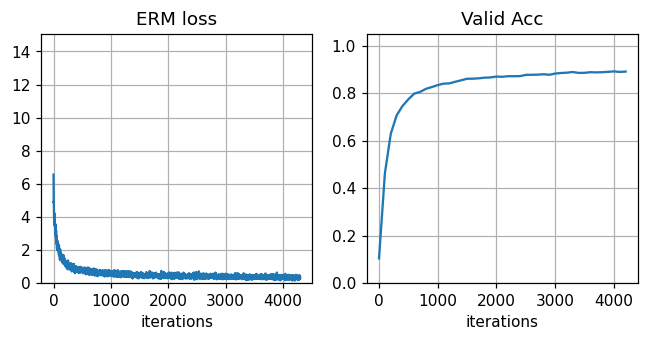

In [136]:
train_dl, valid_dl, test_dl = get_mnist_dl(device=DEVICE)

model = LeNet().to(DEVICE)

for p in model.parameters():
    g = p.view(-1)
    v = torch.normal(mean = torch.full((1, len(g)), 0.), std = torch.full((1, len(g)), 0.1)).to(DEVICE)
    p.data = v.view(p.shape)

opt = torch.optim.SGD(model.parameters(), lr=1e-2)


stats = run_experiment(model, opt, train_dl, valid_dl, test_dl, use_forward_grad=True, num_forward_grad = 10, max_epochs=20)

print_stats(stats)